# ECH - Encuesta continua de hogares 2020

## Objetivos

En esta investigación buscamos determinar cuánto afecta el nivel educativo, la cantidad de hijos y otros indicadores, a la inserción en el mercado laboral de las mujeres uruguayas. Luego de un análisis principal de la base para conocer el contexto general de la investigación, intentaremos crear un algoritmo de clasificación para entender la influencia de distintas variables categóricas en un resultado determinado.

### Librerias a utilizar

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sns.set(rc={'figure.figsize':(30,15)})

### Importar dataset y seleccionar atributos de análisis principales.

Para leer el archivo es necesario contar con la libreria _pyreadstat_

In [2]:
df = pd.read_spss('/Users/anicolon/Desktop/coder_proyecto/ECH_2019/ECH_2019.sav')

df = df.rename(columns={
    'numero': 'id_hogar',
    'e26': 'sexo',
    'e27': 'edad',
    'e29_6': 'ascendencia',
    'e30': 'parentesco',
    'pobpcoac': 'estado_laboral',
    'g126_1': 'sueldo',
    'f99': 'busca_otro_trabajo',
    'f72_2': 'actividad',
    'e49_CV': 'asistencia a enseñanza',
    'e49': 'asistencia alguna vez a enseñanza',
    'e193': 'edu preescolar',
    'e197': 'edu primaria',
    'e201': 'edu media',
    'e212': 'edu técnica',
    'e215': 'edu mag prof',
    'e218': 'edu univ o simil',
    'e221': 'edu terciario no uni',
    'e224': 'edu posgrado',
    'NOMBARRIO': 'barrio',
    'e36': 'estado_civil',
    'e185': 'hijos',
    'e48': 'leer_escribir',
    'e186_1': 'hijos en hogar',
    'e186_2': 'hijos en otro hogar',
    'e186_3': 'hijos en el extranjero',
    'region_4': 'region',
    'estred13': 'estrato',
    'd8_1': 'vivienda'
    })

In [3]:
df = df[[
    'id_hogar', 
    'sexo', 
    'edad', 
    'ascendencia', 
    'parentesco', 
    'estado_laboral', 
    'nper', 
    'sueldo', 
    'busca_otro_trabajo',
    'actividad',
    'asistencia alguna vez a enseñanza',
    'edu preescolar',
    'edu primaria',
    'edu media',
    'edu técnica',
    'edu univ o simil',
    'edu terciario no uni',
    'edu posgrado',
    'edu mag prof',
    'barrio',
    'estado_civil',
    'hijos',
    'hijos en hogar',
    'hijos en otro hogar',
    'hijos en el extranjero',
    'leer_escribir',
    'region',
    'vivienda',
    'estrato'
    ]]

In [4]:
df['sexo'] = df['sexo'].astype('category')
df['barrio'] = df['barrio'].astype('category')

## Primera exposición a los datos

In [5]:
df.sample(2)

,id_hogar,sexo,edad,ascendencia,parentesco,estado_laboral,nper,sueldo,busca_otro_trabajo,actividad,...,barrio,estado_civil,hijos,hijos en hogar,hijos en otro hogar,hijos en el extranjero,leer_escribir,region,vivienda,estrato
48724,2019026185,Mujer,80.0,Blanca,Jefe/a de hogar,Inactivo: jubilado,1.0,0.0,0.0,.,...,8.0,Viudo/a de casamiento,Sí,0.0,1.0,0.0,Sí,Montevideo,Ocupante gratuito y se lo permite un particular,Montevideo Alto
61498,2019033041,Hombre,67.0,Blanca,Jefe/a de hogar,Inactivo: jubilado,1.0,0.0,0.0,.,...,51.0,0.0,0.0,0.0,0.0,0.0,Sí,Montevideo,Propietario de la vivienda y el terreno y ya l...,Montevideo Medio Alto


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107871 entries, 0 to 107870
Data columns (total 29 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   id_hogar                           107871 non-null  object  
 1   sexo                               107871 non-null  category
 2   edad                               107871 non-null  float64 
 3   ascendencia                        107871 non-null  category
 4   parentesco                         107871 non-null  category
 5   estado_laboral                     107871 non-null  category
 6   nper                               107871 non-null  float64 
 7   sueldo                             107871 non-null  float64 
 8   busca_otro_trabajo                 107871 non-null  category
 9   actividad                          107871 non-null  category
 10  asistencia alguna vez a enseñanza  107871 non-null  category
 11  edu preescolar            

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
edad,107871.0,39.878290,23.726435,0.0,19.0,39.0,59.0,98.0
nper,107871.0,2.163417,1.311837,1.0,1.0,2.0,3.0,17.0
sueldo,107871.0,9251.094548,18955.320483,0.0,0.0,0.0,15000.0,900000.0
hijos en hogar,107871.0,0.345199,0.782579,0.0,0.0,0.0,0.0,10.0
hijos en otro hogar,107871.0,0.428336,1.137549,0.0,0.0,0.0,0.0,20.0
hijos en el extranjero,107871.0,0.029628,0.224843,0.0,0.0,0.0,0.0,10.0


### Ascendencia

In [8]:
asc_princ_porcentage = df['ascendencia'].value_counts() / len(df['ascendencia']) * 100

asc_princ_porcentage

Blanca                 94.288548
Afro o negra            4.140130
Indígena                1.445245
Asiática o amarilla     0.057476
0.0                     0.053768
Otra                    0.014833
Name: ascendencia, dtype: float64

## Estudio de la composición de los hogares uruguayos

### Cantidad de personas que conforman un grupo familiar

In [9]:
composicion_familiar = pd.pivot_table(df, index='id_hogar', columns='parentesco',values=['nper'], aggfunc='count')

composicion_familiar['totales'] = composicion_familiar.apply(lambda x:x.sum(), axis=1)

composicion_familiar = composicion_familiar.sort_values(by='totales', ascending=False)

composicion_familiar['totales'].value_counts()

2     12758
1     11406
3      8379
4      6240
5      2390
6       819
7       305
8       124
9        44
10       22
11       11
12        4
16        2
17        1
14        1
13        1
Name: totales, dtype: int64

## Organización familiar

In [10]:
df['parentesco'].value_counts()

Jefe/a de hogar                            42507
Esposo/a o compañero/a                     22574
Hijo/a de ambos                            20188
Hijo/a solo del jefe/a                     12492
Nieto/a                                     3311
Hijo/a solo del esposo/a compañero/a        1965
Padre/madre                                 1148
Hermano/a                                    937
Otro pariente                                839
Yerno/nuera                                  766
Otro no pariente                             729
Suegro/a                                     254
Cuñado/a                                     145
Servicio doméstico o familiar del mismo       16
Name: parentesco, dtype: int64

<AxesSubplot:ylabel='sexo'>

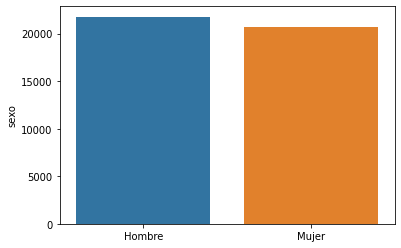

In [11]:
jefes_de_hogar_sexo = df[df['parentesco'].str.contains('Jefe')]['sexo'].value_counts()

sns.barplot(x=jefes_de_hogar_sexo.index, y=jefes_de_hogar_sexo)

In [12]:
df['suma_hijos'] = df[['hijos en hogar','hijos en otro hogar','hijos en el extranjero',]].apply(lambda x:x.sum(), axis=1)

df['suma_hijos'].value_counts()

0.0     73223
2.0     12488
1.0      9347
3.0      6625
4.0      2928
5.0      1374
6.0       801
7.0       443
8.0       266
9.0       156
10.0      113
11.0       52
12.0       28
13.0       15
14.0        5
15.0        5
20.0        1
21.0        1
Name: suma_hijos, dtype: int64

In [13]:
df.to_csv('ECH_2019.csv')

## Situación laboral

In [14]:
df['estado_laboral'].value_counts()

Ocupados                                      49036
Menores de 14 años                            18064
Inactivo: jubilado                            16025
Inactivo: estudiante                           8216
Inactivo: realiza los quehaceres del hogar     5936
Inactivo: pensionista                          4438
Desocupados propiamente dichos                 3409
Inactivo: otro                                 1291
Desocupados buscan trabajo por primera vez      787
Inactivo: rentista                              414
Desocupados en seguro de paro                   255
Name: estado_laboral, dtype: int64

<AxesSubplot:xlabel='estado_laboral', ylabel='count'>

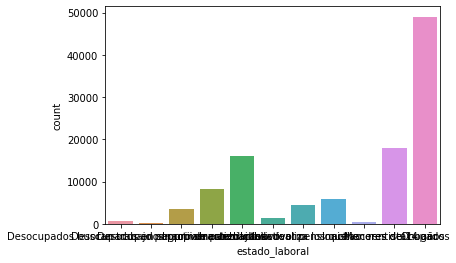

In [15]:
sns.countplot(x=df['estado_laboral'])

In [16]:
df['estado_laboral'].value_counts() / len(df['estado_laboral']) * 100

Ocupados                                      45.458001
Menores de 14 años                            16.745928
Inactivo: jubilado                            14.855707
Inactivo: estudiante                           7.616505
Inactivo: realiza los quehaceres del hogar     5.502869
Inactivo: pensionista                          4.114173
Desocupados propiamente dichos                 3.160256
Inactivo: otro                                 1.196800
Desocupados buscan trabajo por primera vez     0.729575
Inactivo: rentista                             0.383792
Desocupados en seguro de paro                  0.236393
Name: estado_laboral, dtype: float64

In [17]:
df.groupby(by='estado_laboral').mean()

,edad,nper,sueldo,hijos en hogar,hijos en otro hogar,hijos en el extranjero,suma_hijos
estado_laboral,,,,,,,
Desocupados buscan trabajo por primera vez,20.670902,3.035578,25.031766,0.151207,0.022872,0.000000,0.174079
Desocupados en seguro de paro,39.074510,1.780392,3602.415686,0.458824,0.254902,0.019608,0.733333
Desocupados propiamente dichos,33.915518,2.206512,1559.024641,0.596656,0.310355,0.018774,0.925785
Inactivo: estudiante,17.345180,3.260346,93.646543,0.033350,0.004260,0.000000,0.037610
Inactivo: jubilado,72.800936,1.348206,123.482059,0.171108,0.959126,0.082683,1.212917
Inactivo: otro,33.783114,2.883036,618.094500,0.237026,0.302866,0.023238,0.563129
Inactivo: pensionista,64.425192,1.683641,22.757999,0.370662,1.675530,0.114015,2.160207
Inactivo: realiza los quehaceres del hogar,46.889319,1.857311,317.843666,1.107311,1.102426,0.056941,2.266678
Inactivo: rentista,58.461353,1.528986,72.463768,0.541063,0.850242,0.123188,1.514493


<AxesSubplot:xlabel='ascendencia', ylabel='sueldo'>

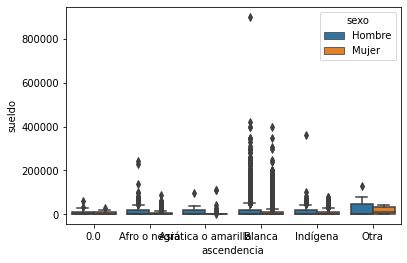

In [18]:
# df = df[~df['ascendencia'].str.contains('Sin dato')]

sns.boxplot(data=df, x='ascendencia', y='sueldo', hue='sexo')

<AxesSubplot:xlabel='edad', ylabel='sueldo'>

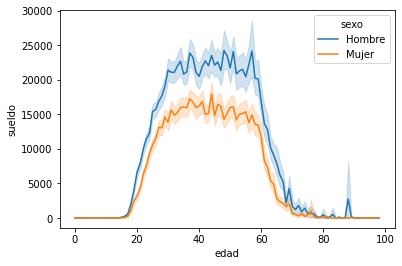

In [19]:
sns.lineplot(data=df, x='edad', y='sueldo',hue='sexo')

## Comienzo de análisis más profundo. 

En este punto nos empezamos a centrar en las madres, jefas de hogares.

In [20]:
df['parentesco_num'] = df['parentesco'].cat.codes

df[['parentesco_num', 'parentesco']].value_counts()

parentesco_num  parentesco                             
6               Jefe/a de hogar                            42507
1               Esposo/a o compañero/a                     22574
3               Hijo/a de ambos                            20188
5               Hijo/a solo del jefe/a                     12492
7               Nieto/a                                     3311
4               Hijo/a solo del esposo/a compañero/a        1965
10              Padre/madre                                 1148
2               Hermano/a                                    937
9               Otro pariente                                839
13              Yerno/nuera                                  766
8               Otro no pariente                             729
12              Suegro/a                                     254
0               Cuñado/a                                     145
11              Servicio doméstico o familiar del mismo       16
dtype: int64

Considerando Hijo/a de ambos, Hijo/a solo del jefe/a, Nieto/a, Hijo/a solo del esposo/a compañero/a para ampliar un poco la muestra y tener en cuenta que monomarental puede incluir a los hijos del compañero porque la jefa de hogar estaría a cargo de ellos.

In [21]:
mask = df["parentesco_num"].isin([3, 4, 5, 6, 7])
df = df[mask]

df["monomarental"] = np.NaN
df["monomarental"] = (
    df["monomarental"]
    .apply(lambda x: "monomarental")
    .where(df["parentesco_num"] == 6)
    .where(df["sexo"].str.contains("Mujer"))
)

### Empezamos a centrarnos en las hogares monomarentales

In [22]:
# Eliminamos hogares con jefes de hogar masculinos
df_monomarental_y_familia = df.copy().drop(
    labels=list(
        df.loc[(df["sexo"].str.contains("Hombre")) & (df["parentesco_num"] == 6)].index
    )
)

df_monomarental_y_familia.sample(5)

,id_hogar,sexo,edad,ascendencia,parentesco,estado_laboral,nper,sueldo,busca_otro_trabajo,actividad,...,hijos en hogar,hijos en otro hogar,hijos en el extranjero,leer_escribir,region,vivienda,estrato,suma_hijos,parentesco_num,monomarental
39091,2019021032,Mujer,9.0,Blanca,Hijo/a solo del jefe/a,Menores de 14 años,4.0,0.0,0.0,.,...,0.0,0.0,0.0,Sí,Montevideo,Ocupante gratuito y se lo permite un particular,Montevideo Medio Bajo,0.0,5,NaN
73890,2019039855,Hombre,13.0,Blanca,Hijo/a solo del jefe/a,Menores de 14 años,2.0,0.0,0.0,.,...,0.0,0.0,0.0,Sí,Interior - Localidades de 5.000 habitantes o más,Ocupante gratuito y se lo permite un particular,Litoral Sur,0.0,5,NaN
65887,2019035460,Hombre,11.0,Blanca,Hijo/a de ambos,Menores de 14 años,5.0,0.0,0.0,.,...,0.0,0.0,0.0,Sí,Interior - Localidades de 5.000 habitantes o más,Ocupante gratuito y se lo permite un particular,Centro Sur,0.0,3,NaN
69740,2019037563,Mujer,19.0,Blanca,Hijo/a solo del jefe/a,Ocupados,2.0,12000.0,Sí,Restaurantes y otros servicios de comidas móviles,...,0.0,0.0,0.0,Sí,Interior - Localidades de 5.000 habitantes o más,Inquilino o arrendatario de la vivienda,Costa Este,0.0,5,NaN
81215,2019043792,Mujer,21.0,Blanca,Hijo/a de ambos,Inactivo: estudiante,3.0,0.0,0.0,.,...,0.0,0.0,0.0,Sí,Interior - Localidades de 5.000 habitantes o más,Inquilino o arrendatario de la vivienda,Centro Sur,0.0,3,NaN


## Investigamos el contexto de las jefas de hogar activas laboralmente

In [23]:
df_monomarental = df_monomarental_y_familia.copy()[df_monomarental_y_familia['monomarental'].notna()]

df_monomarental.sample(5)

df_monomarental[[
    'id_hogar', 
    'sexo', 
    'edad', 
    'ascendencia', 
    'parentesco', 
    'estado_laboral', 
    'nper', 
    'sueldo', 
    'busca_otro_trabajo',
    'actividad',
    'asistencia alguna vez a enseñanza',
    'edu preescolar',
    'edu primaria',
    'edu media',
    'edu técnica',
    'edu univ o simil',
    'edu terciario no uni',
    'edu posgrado',
    'edu mag prof',
    'barrio',
    'estado_civil',
    'hijos',
    'hijos en hogar',
    'hijos en otro hogar',
    'hijos en el extranjero',
    'suma_hijos',
    'leer_escribir'
    ]].to_csv('monomarental.csv', index=None)

In [24]:
df_monomarental['estado_laboral'].value_counts()

Ocupados                                      10877
Inactivo: jubilado                             5273
Inactivo: pensionista                          2138
Inactivo: realiza los quehaceres del hogar     1503
Desocupados propiamente dichos                  626
Inactivo: rentista                              142
Inactivo: estudiante                             62
Desocupados en seguro de paro                    54
Inactivo: otro                                   33
Desocupados buscan trabajo por primera vez       23
Menores de 14 años                                0
Name: estado_laboral, dtype: int64

In [25]:
df_monomarental.groupby(by='estado_laboral').mean()

,edad,nper,sueldo,hijos en hogar,hijos en otro hogar,hijos en el extranjero,suma_hijos,parentesco_num
estado_laboral,,,,,,,,
Desocupados buscan trabajo por primera vez,27.739130,1.0,0.000000,0.782609,0.521739,0.000000,1.304348,6.0
Desocupados en seguro de paro,43.166667,1.0,3572.518519,1.111111,0.777778,0.055556,1.944444,6.0
Desocupados propiamente dichos,41.044728,1.0,1553.162939,1.436102,0.896166,0.041534,2.373802,6.0
Inactivo: estudiante,26.500000,1.0,604.838710,0.612903,0.064516,0.000000,0.677419,6.0
Inactivo: jubilado,73.846767,1.0,114.925090,0.259435,1.785701,0.156078,2.201214,6.0
Inactivo: otro,55.363636,1.0,0.000000,1.151515,2.151515,0.151515,3.454545,6.0
Inactivo: pensionista,72.115061,1.0,23.620206,0.428906,2.442937,0.156221,3.028064,6.0
Inactivo: realiza los quehaceres del hogar,48.506321,1.0,217.099135,1.377246,1.242182,0.063872,2.683300,6.0
Inactivo: rentista,58.852113,1.0,211.267606,0.697183,1.133803,0.169014,2.000000,6.0


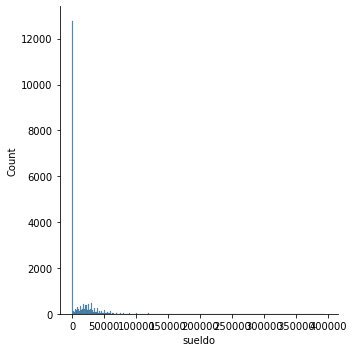

In [26]:
sns.displot(df_monomarental['sueldo'])

### En la gráfica anterior nos enfrentamos a la necesidad de eliminar outliers para realizar un análisis más ajustado a la realidad general de las madres

In [27]:
df_monomarental_sinoutliers = df_monomarental[
    df_monomarental["estado_laboral"].str.contains("Ocupados")
].copy()

df_monomarental_sinoutliers = df_monomarental_sinoutliers[
    df_monomarental_sinoutliers["edad"] > 14
]

df_monomarental_sinoutliers = df_monomarental_sinoutliers[
    df_monomarental_sinoutliers["sueldo"] > 0
]

In [28]:
quantil_99 = df_monomarental_sinoutliers["sueldo"].quantile(0.99)
print(quantil_99)

df_monomarental_sinoutliers = df_monomarental_sinoutliers[
    df_monomarental_sinoutliers["sueldo"] < quantil_99
]

quartil_1 = df_monomarental_sinoutliers["sueldo"].quantile(0.25)
quartil_3 = df_monomarental_sinoutliers["sueldo"].quantile(0.75)

iqr = quartil_3 - quartil_1

df_monomarental_sinoutliers = df_monomarental_sinoutliers[
    df_monomarental_sinoutliers["sueldo"] < quartil_3 + 1.5 * iqr
]

df_monomarental_sinoutliers = df_monomarental_sinoutliers[
    df_monomarental_sinoutliers["sueldo"] > quartil_1 - 1.5 * iqr
]

118600.00000000036


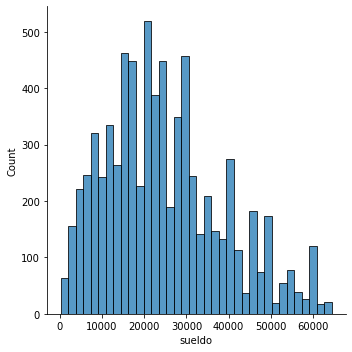

In [29]:
sns.displot(df_monomarental_sinoutliers['sueldo'])

### Sueldo por cantidad de hijos

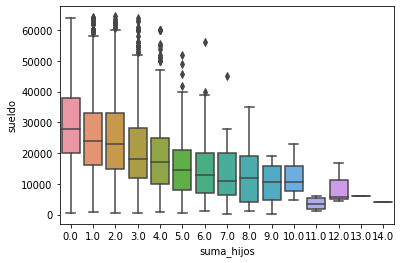

In [30]:
sns.boxplot(data=df_monomarental_sinoutliers, x='suma_hijos', y='sueldo')

plt.show()

In [31]:
df_monomarental_sinoutliers[['edad', 'sueldo', 'suma_hijos']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
edad,7435.0,44.188568,11.854204,17.0,35.0,44.0,53.0,83.0
sueldo,7435.0,24601.295763,13908.398321,200.0,14550.0,23000.0,32400.0,64500.0
suma_hijos,7435.0,1.762071,1.569745,0.0,1.0,2.0,2.0,14.0


### Sueldo por ascendencia

<AxesSubplot:xlabel='ascendencia', ylabel='sueldo'>

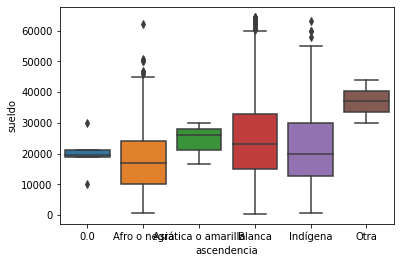

In [32]:
sns.boxplot(data=df_monomarental_sinoutliers, x='ascendencia', y='sueldo')

In [33]:
df_monomarental_sinoutliers.sample(5)

,id_hogar,sexo,edad,ascendencia,parentesco,estado_laboral,nper,sueldo,busca_otro_trabajo,actividad,...,hijos en hogar,hijos en otro hogar,hijos en el extranjero,leer_escribir,region,vivienda,estrato,suma_hijos,parentesco_num,monomarental
80079,2019043181,Mujer,40.0,Blanca,Jefe/a de hogar,Ocupados,1.0,9000.0,No,Actividades de los hogares en calidad de emple...,...,1.0,0.0,0.0,Sí,Interior - Localidades de 5.000 habitantes o más,Propietario de la vivienda y el terreno y ya l...,Interior Norte,1.0,6,monomarental
8480,2019004522,Mujer,52.0,Blanca,Jefe/a de hogar,Ocupados,1.0,18000.0,Sí,Limpieza general de edificios,...,0.0,0.0,0.0,Sí,Montevideo,Inquilino o arrendatario de la vivienda,Montevideo Bajo,0.0,6,monomarental
107427,2019057831,Mujer,25.0,Blanca,Jefe/a de hogar,Ocupados,1.0,25000.0,No,Elaboración de comidas y platos preparados,...,0.0,0.0,0.0,Sí,Interior - Localidades de 5.000 habitantes o más,Inquilino o arrendatario de la vivienda,Costa Este,0.0,6,monomarental
103516,2019055747,Mujer,39.0,Blanca,Jefe/a de hogar,Ocupados,1.0,35000.0,No,Comercio al por menor en almacenes no especial...,...,2.0,0.0,0.0,Sí,Montevideo,Inquilino o arrendatario de la vivienda,Montevideo Medio Bajo,2.0,6,monomarental
13380,2019007178,Mujer,35.0,Blanca,Jefe/a de hogar,Ocupados,1.0,43000.0,No,Otros tipos de enseñanza,...,0.0,0.0,0.0,Sí,Montevideo,Miembro de cooperativa de vivienda,Montevideo Medio,0.0,6,monomarental
